# V.1 Exploring the green reds

### a) Funciton to display the Scatter Plot Matrix

In [1]:
import numbers
import math
import itertools
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
red_wine = pd.read_csv('winequality-red.csv', sep=';')
red_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


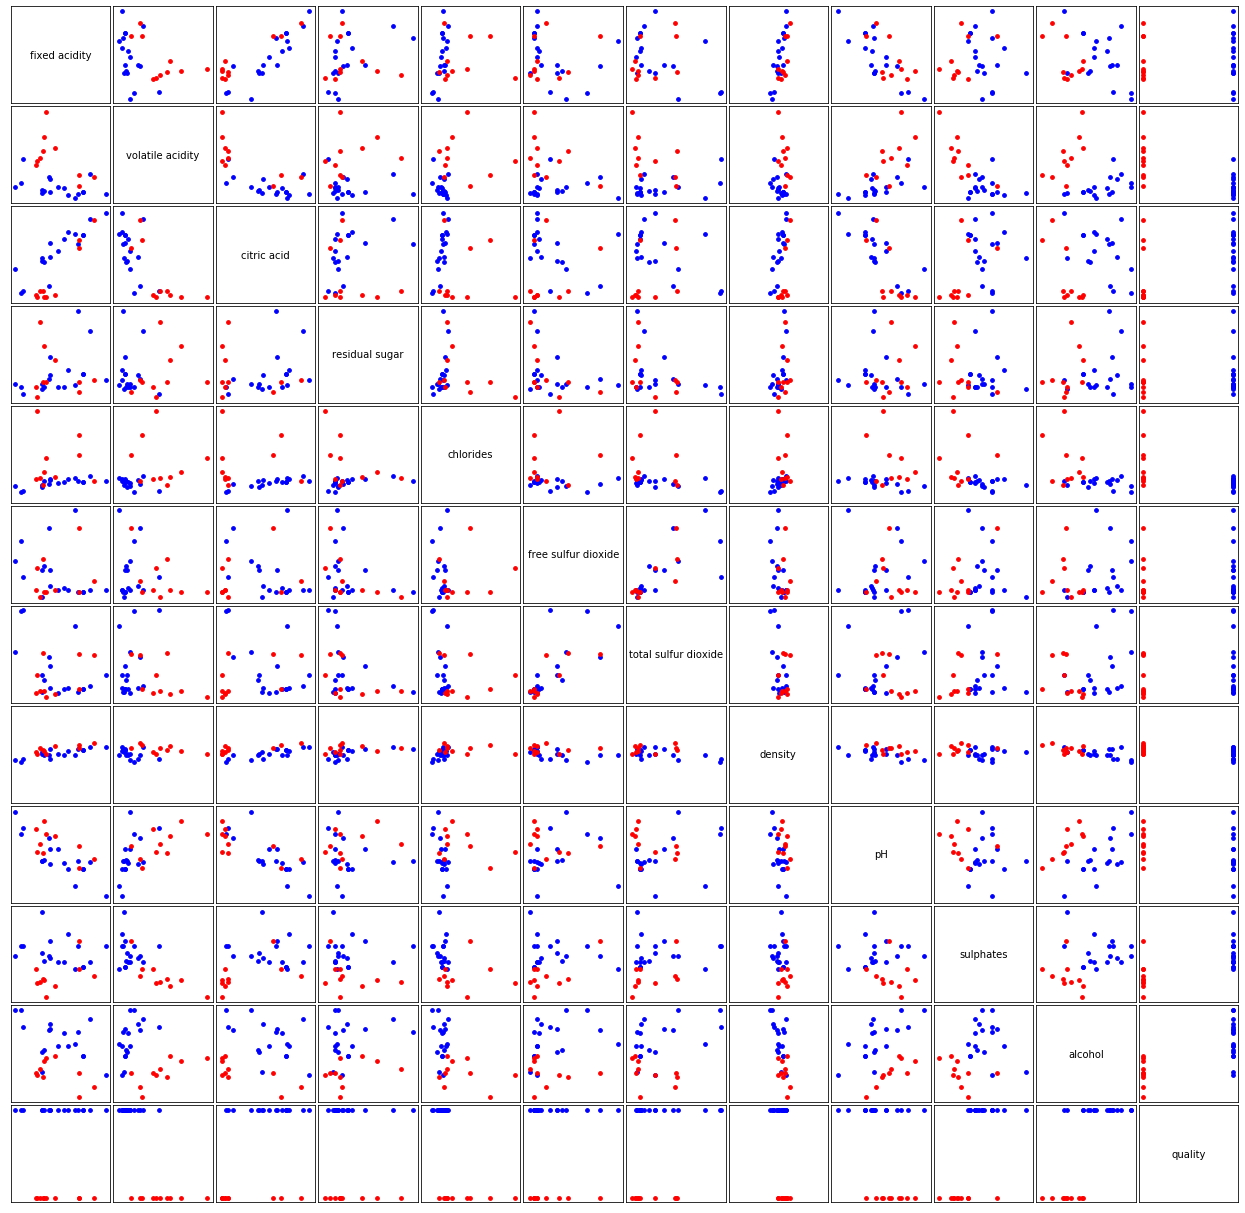

In [3]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
    """
    Function to plot the Scatter Matrix.
    If shows relations between each pair of wine parameters.
    ----------
    Parameters
    ----------
    wine_data: Pandas Data Frame, chemical elements and quality for wines data set
    good_threshold: int, the quality for good wines
    bad_threshold: int, the quality for bad wines
    save_plot: boolean, deafault: False, if True -> save scatter matrix as png
    """
    rows, cols = wine_data.shape
    fig, axes = plt.subplots(nrows=cols, ncols=cols, figsize=(22, 22))
    fig.subplots_adjust(hspace=0.03, wspace=0.03)
    good_wines = wine_data[wine_data['quality'] >= good_threshold]
    bad_wines = wine_data[wine_data['quality'] <= bad_threshold]
    good_wine_color = "blue"
    bad_wine_color = "red"

    for ax in axes.flat:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    
    for i in range(cols):
        for j in range(i + 1, cols):
            axes[i, j].scatter(good_wines.iloc[:, j], good_wines.iloc[:, i], c=good_wine_color, s=14)
            axes[i, j].scatter(bad_wines.iloc[:, j], bad_wines.iloc[:, i], c=bad_wine_color, s=14)
            axes[j, i].scatter(good_wines.iloc[:, i], good_wines.iloc[:, j], c=good_wine_color, s=14)
            axes[j, i].scatter(bad_wines.iloc[:, i], bad_wines.iloc[:, j], c=bad_wine_color, s=14)

    for i, label in enumerate(wine_data.columns):
        axes[i,i].annotate(label, (0.5, 0.5), xycoords='axes fraction',
                           ha='center', va='center')

    if save_plot:
        fig.savefig('scatterplot_matrix.png')

    return fig

fig = plot_scatter_matrix(red_wine, 8, 3)

### b) Which factors do you think will be most useful to your perceptron for distinguishing high quality vs. low quality wines?
I think, the best factors for distinguishing are:
* Alcohol
* Sulphates
* Volatile Acidity

And the worst factors:
* Residual sugar
* Free sulfur dioxide
* pH

# V.2 Learning to perceptron

### a) Implement a perceptron that:
* Has randomly initialized weights and bias
* Uses the Rosenblatt perceptron learning rule (with changeable learning rate)
* Utilizes the heaviside step activation function (discrete version)

### b) You’ll need to implement a function to train your perceptron. Your training function should take in your red wine data as a parameter and should:
* Have a way to specify number of training epochs
* Train your perceptron until it makes no errors, if training epochs is set to 0,
* Have a way to specify learning rate.
* Return a list of python tuples containing (performance):

In [4]:
def dot(a, b):
    if isinstance(b, numbers.Integral) or isinstance(b, numbers.Real):
        return [ai * b for ai in a]
    elif len(a) != len(b):
        raise ValueError("a's and b's lengths must be equal.")
    return sum(ai * bi for ai, bi in zip(a, b))        

def train_split(wine_data, features_list, good_threshold=8, bad_threshold=3, binary=True):
    """
    Splits the wine data into inputs list and answers list.
    ----------
    Parameters
    ----------
    wine_data: Pandas Data Frame, chemical elements and quality for wines data set
    features_list: list, containing feature column names
    good_threshold, int, default: 8, quality of good wines
    bad_threshold, int, default: 3, quality of bad wines
    ------------
    Return Value
    ------------
    A tuple, containing features data and answers.
    """
    test_data = wine_data[(wine_data['quality'] >= good_threshold) | (wine_data['quality'] <= bad_threshold)]
    test_data = test_data.reset_index(drop=True)
    test_data.loc[test_data['quality'] <= bad_threshold, 'quality'] = 0.0 if binary else -1.0
    test_data.loc[test_data['quality'] >= good_threshold, 'quality'] = 1.0
    X = test_data.loc[:, features_list]
    y = test_data.loc[:, 'quality']
    return tuple([X.values, y.values])

In [31]:
class Perceptron:
    def __init__(self, learning_rate, epochs=0, seed=999):
        """
        Parameters
        ----------
        learning_rate: float, speed of weights updating
        epochs: int, default: 0, if 0 then fit works till finds the perfect solution
        seed: int, default: 999, random seed for random function
        """
        if epochs < 0:
            raise ValueError("Epochs must be more than or equal to zero")
        self._w = None
        self.lr = learning_rate
        self.epochs = epochs
        self.performance = []
        random.seed(seed)
        
    def fit(self, X, y):
        """
        Function to train perceptron.
        It changes weights after each epoch to make more accurate predictions.
        ----------
        Parameters
        ----------
        X: Array with wine chemical elements
        y: Vector with qualities equal to 1 if wine is good, otherwise 0
        ------------
        Return Value
        ------------
        performance: list of tuples in the following format: (current_epoch, epoch_errors, [array_of_weights], bias)
        """
        epoch = 0
        self.performance.clear()
        self._w = [random.uniform(-1, 1) for _ in range(X.shape[1] + 1)]
        while epoch < self.epochs or self.epochs == 0:
            epoch_errors = 0
            for xi, target in zip(X, y):
                prediction = self.predict(xi)
                error = target - prediction
                self._w[0] += (self.lr * error)
                self._w[1:] += (self.lr * error * xi)
                epoch_errors += int(error != 0)
            self.performance.append((epoch, epoch_errors, self._w[1:], self._w[0]))
            if self.epochs == 0 and epoch_errors == 0:
                break
            epoch += 1
        return self.performance
    
    def _net_input(self, X):
        return dot(self._w[1:], X) + self._w[0]
    
    def _activation(self, X):
        """Unit step activation function"""
        return 1.0 if self._net_input(X) >= 0 else 0.0
    
    def predict(self, X):
        return self._activation(X)

In [32]:
X, y = train_split(red_wine, ['alcohol', 'volatile acidity'], good_threshold=8, bad_threshold=3)
perceptron = Perceptron(0.1, epochs=0)
performance = perceptron.fit(X, y)

### c) Now that you have a perceptron, a way to train your perceptron, and some data, you need a way to confirm that your perceptron actually works.
Write a function that will take the output of your perceptron training function and your red wine data and generate two plots in one figure:
* The first plot should plot the number of errors your perceptron made as a function of epoch. Be careful with how you calculate errors!
* The second plot should plot the decision boundary of your perceptron and also show ‘good’ and ‘bad’ wine data points on the final training epoch. This second plot should also shade ‘good’ and ‘bad’ areas!
* Your function should allow the user to specify a specific epoch and see what the decision boundary of the perceptron was on that epoch. If a negative epoch is given, cause the plots to show the last epoch.

In [33]:
def plot_decision_boundary(ax, stat, wine_data, features_list, good_thres, bad_thres, epoch):
    """
    Plots Decision Boundary. It creates a graph with 2 axes(2 features).
    Then it plots this data as a scatter matrix.
    Weights, which perceptron found during its training, represents the line from (x:0, y:0 + bias) to (x:w1, y:w2).
    And that line is perpendicular to the line, which divides the wine into bad and good.
    ----------
    Parameters
    ----------
    ax: Matplotlib Axis, onto which the decision boundary is plotted
    stat: a performance list of tuples, regrouped to lists with separated params in each column
    wine_data: Pandas Data Frame, should contain only good and bad wines, without intermediate
    features_list: a list of 2 features names
    good_thres: int, good wine quality
    bad_thres: int, bad_wine_quality
    epoch: number of epoch, for which performance is plotted, if < 0 then the last epoch is plotted
    """
    x_min = wine_data[features_list[0]].min()
    x_max = wine_data[features_list[0]].max()
    y_min = wine_data[features_list[1]].min()
    y_max = wine_data[features_list[1]].max()
    good_wines = wine_data[wine_data['quality'] >= good_thres]
    bad_wines = wine_data[wine_data['quality'] <= bad_thres]
    w1, w2 = stat[2][epoch]
    b = stat[3][epoch]
    slope = -(b / w2) / (b / w1)
    y_intercept = -b / w2
    
    x = (math.floor(x_min) - 1, math.ceil(x_max) + 2)
    y = [slope * xi + y_intercept for xi in x]
    
    ax.set_xlim(x_min - 0.1, x_max + 0.1)
    ax.set_ylim(y_min - 0.1, y_max + 0.1)
    ax.set_title(f"Decision boundary on epoch: {epoch}")
    ax.set_xlabel(features_list[0])
    ax.set_ylabel(features_list[1])
    ax.plot(x, y, c='magenta', linestyle='--', label='Decision Boundary')
    ax.fill_between(x, y, y_max + 0.1, color='cyan', alpha=0.4, label=f'Good Wines (>= {good_thres})')
    ax.fill_between(x, y, y_min - 0.1, color='yellow', alpha=0.4, label=f'Bad Wines (<= {bad_thres})')
    ax.scatter(good_wines.loc[:, features_list[0]], good_wines.loc[:, features_list[1]], s=120, c='blue', marker='s')
    ax.scatter(bad_wines.loc[:, features_list[0]], bad_wines.loc[:, features_list[1]], s=120, c='orange', marker='^')
    ax.legend(loc='best')

def plot_performance(performance, wine_data, features_list, good_thres, bad_thres, epoch=-1, save_plot=False):
    """
    Function to plot perceptron's results
    ----------
    Parameters
    ----------
    performance: list of tuples in the following format: (current_epoch, epoch_errors, [array_of_weights], bias)
    wine_data: Pandas Data Frame, chemical elements and quality for wines data set
    features_list: list, containing 2 features, used to predict quality
    good_thres: int, good wine quality
    bad_thres: int, bad_wine_quality
    epoch: int, default < =, epoch to show decision boundary for. Should be < 0 to show the last epoch.
    save_plot: boolean, default: False, if True then saves the plot to the file: `plot_performance.png`
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 10))
    stat = list(zip(*performance))
    if epoch < 0:
        epoch = len(stat[0]) - 1

    axes[0].set_title("Errors per epoch")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Errors")
    axes[0].plot(stat[0], stat[1], color='brown')
    
    good_or_bad_wines = wine_data[(wine_data['quality'] >= good_thres) | (wine_data['quality'] <= bad_thres)]
    plot_decision_boundary(axes[1], stat, good_or_bad_wines, features_list, good_thres, bad_thres, epoch)

    if save_plot:
        fig.savefig('plot_performance.png')
    return fig

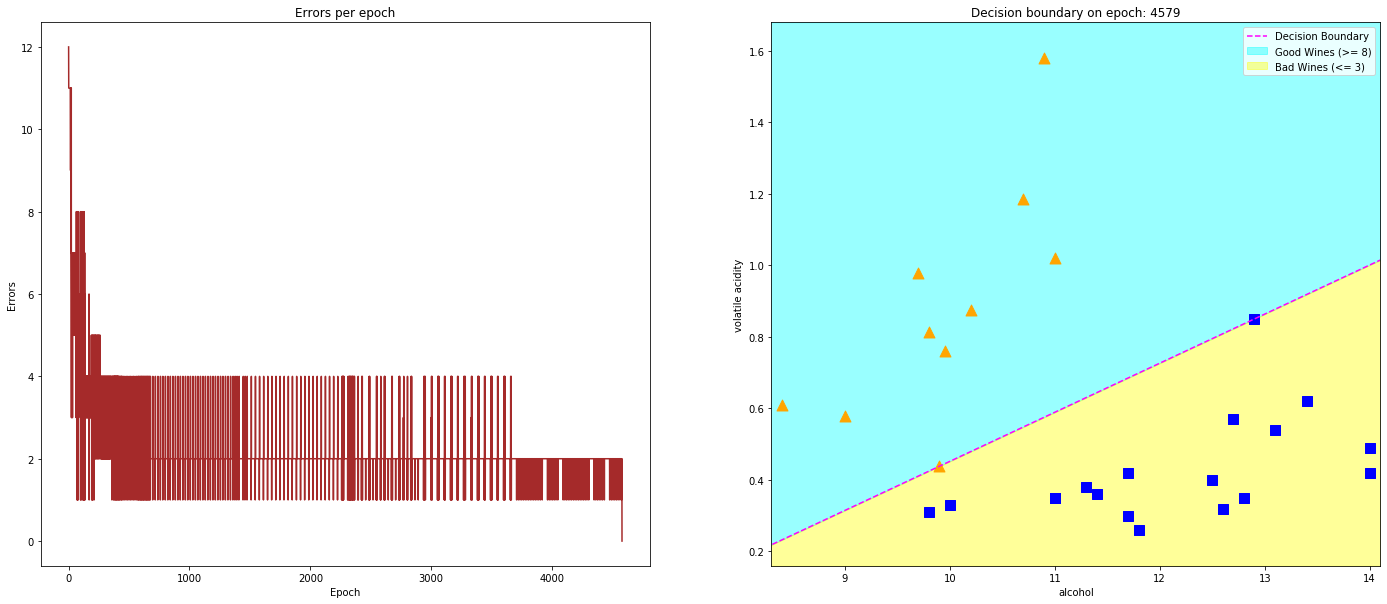

In [34]:
fig = plot_performance(performance, red_wine, ['alcohol', 'volatile acidity'], 8, 3)

### d) Your perceptron appears to work. . . but why is it taking so many epochs to train?
Maybe you can modify the red wine data to help the perceptron learn more quickly?
Use the function you just created in part c) to plot and verify that your
perceptron is learning more efficiently!

In [35]:
def features_scale(wine_data):
    """Scales the wine data using min-max scaling."""
    scaled_data = wine_data.copy()
    for feature in scaled_data.columns:
        if feature == 'quality':
            continue
        col = scaled_data[feature]
        scaled_data.loc[:, feature] = (col - col.min()) / (col.max() - col.min())
    return scaled_data

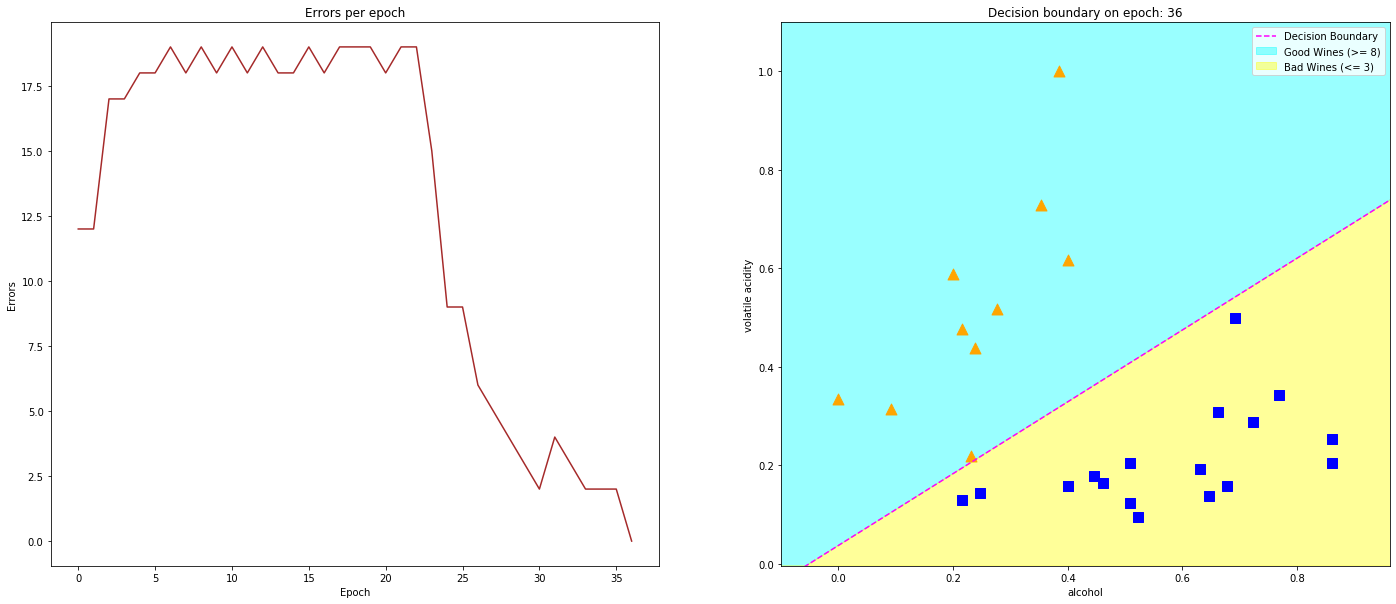

In [36]:
scaled_data = features_scale(red_wine)
X, y = train_split(scaled_data, ['alcohol', 'volatile acidity'], 8, 3)
perceptron = Perceptron(learning_rate=0.01)
performance = perceptron.fit(X, y)
fig = plot_performance(performance, scaled_data, ['alcohol', 'volatile acidity'], 8, 3)

# V.3 My fair ADALINE

### a) Marvin notices and chides you for torturing your perceptron. Why?
Because Perceptron works correctly only if data is perfectly linearly separable. Otherwise, it never stops tring to optimise the weights.

Final number of errors: 32


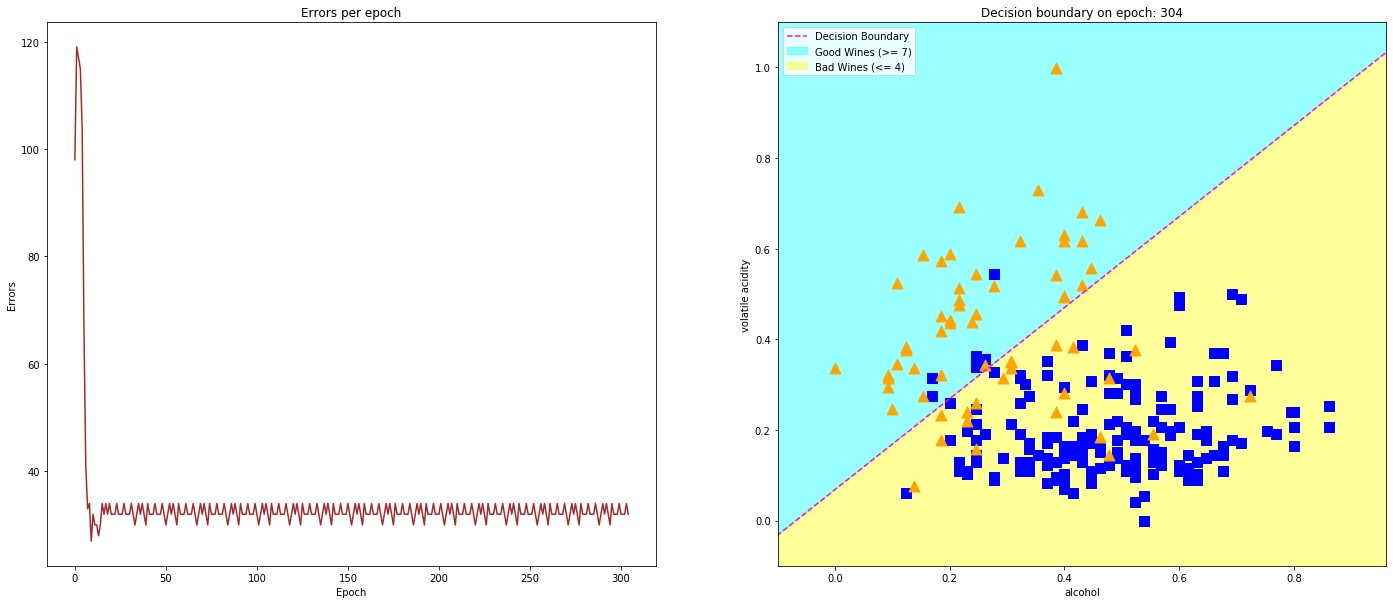

In [41]:
X, y = train_split(scaled_data, ['alcohol', 'volatile acidity'], 7, 4)
perceptron = Perceptron(learning_rate=0.01, epochs=305)
performance = perceptron.fit(X, y)
print(f"Final number of errors: {performance[-1][1]}")
fig = plot_performance(performance, scaled_data, ['alcohol', 'volatile acidity'], 7, 4)

### b)  Implement an ADALINE that:
* Has randomly initialized weights and bias
* Uses a linear activation function and some kind of quantizer
* Uses the Widrow-Hoff learning rule

### c) You’ll need to implement a function to train your ADALINE. Your training function should:
* Take in your red wine data as a parameter
* Have a way to specify number of training epochs
* If training epochs is set to 0, your ADALINE should train until it converges on a good set of weights.
* Have a way to specify learning rate.
* Have an option to perform either online learning or batch learning

In [102]:
class Adaline:
    def __init__(self, learning_rate, epochs=0, seed=999):
        """
        Parameters
        ----------
        learning_rate: float, speed of weights updating
        epochs: int, default: 0, if 0 then fit works till finds the optimal weights
        seed: int, default: 999, random seed for random function
        """
        if epochs < 0:
            raise ValueError("Epochs must be more than or equal to zero")
        self._w = None
        self.lr = learning_rate
        self.epochs = epochs
        self.performance = []
        random.seed(seed)
    
    def fit(self, X, y, sgd=False):
        """
        Function to train adaline neuron.
        It changes weights after each epoch to make more accurate predictions using (stochastic) gradient descent.
        ----------
        Parameters
        ----------
        X: Array with wine chemical elements
        y: Vector with qualities equal to 1 if wine is good, otherwise -1
        sgd: boolean, default: False, if True stochastic gradient descent is used
        ------------
        Return Value
        ------------
        performance: list of tuples in the following format: (current_epoch, epoch_errors, [array_of_weights], bias, SSE)
        """
        epoch = 0
        self.performance.clear()
        self._w = [random.uniform(-1, 1) for _ in range(X.shape[1] + 1)]
        while epoch < self.epochs or self.epochs == 0:
            epoch_errors = []
            sum_errors = 0.0
            for xi, target in zip(X, y):
                output = self._activation(xi)
                error = target - output
                sum_errors += error**2
                epoch_errors.append(error)
                if sgd:
                    self._w[1:] += self.lr * error * xi
                    self._w[0] += self.lr * error
            if not sgd:
                self._w[1:] += self.lr * dot(X, epoch_errors)
                self._w[0] += self.lr * sum(epoch_errors)
            clasif_errors = self.get_accuracy(X, y)
            self.performance.append((epoch, clasif_errors, self._w[1:], self._w[0], sum_errors))
            if epoch > 50:
                errors_diff = abs(sum_errors - self.performance[-50][-1])
                if self.epochs == 0 and errors_diff <= 0.005 * sum_errors:
                    break
            epoch += 1
        return self.performance

    def _net_input(self, X):
        return dot(X, self._w[1:]) + self._w[0]

    def _activation(self, X):
        """Linear activation function"""
        return self._net_input(X)
    
    def predict(self, X):
        return 1 if self._activation(X) >= 0 else -1
    
    def get_accuracy(self, X, y):
        errors = 0
        for xi, target in zip(X, y):
            errors += int(self.predict(xi) != target)
        return errors
    
    @classmethod
    def choose_learning_rate(cls, X, y, n_iter, sgd=False):
        adaline = cls(0, epochs=150, seed=999)
        best_score = None
        best_lr = None
        for _ in range(n_iter):
            lr = round(random.uniform(0.0005, 0.005), 4)
            adaline.lr = lr
            performance = adaline.fit(X, y, sgd)
            fig = plot_performance(performance, scaled_data, ['alcohol', 'volatile acidity'], 7, 4)
            plt.show(fig)
            print(f"Number of errors: {performance[-1][1]}")
            if best_score is None or best_score > performance[-1][1]:
                best_score = performance[-1][1]
                best_lr = lr
        return best_lr

Final number of errors: 27


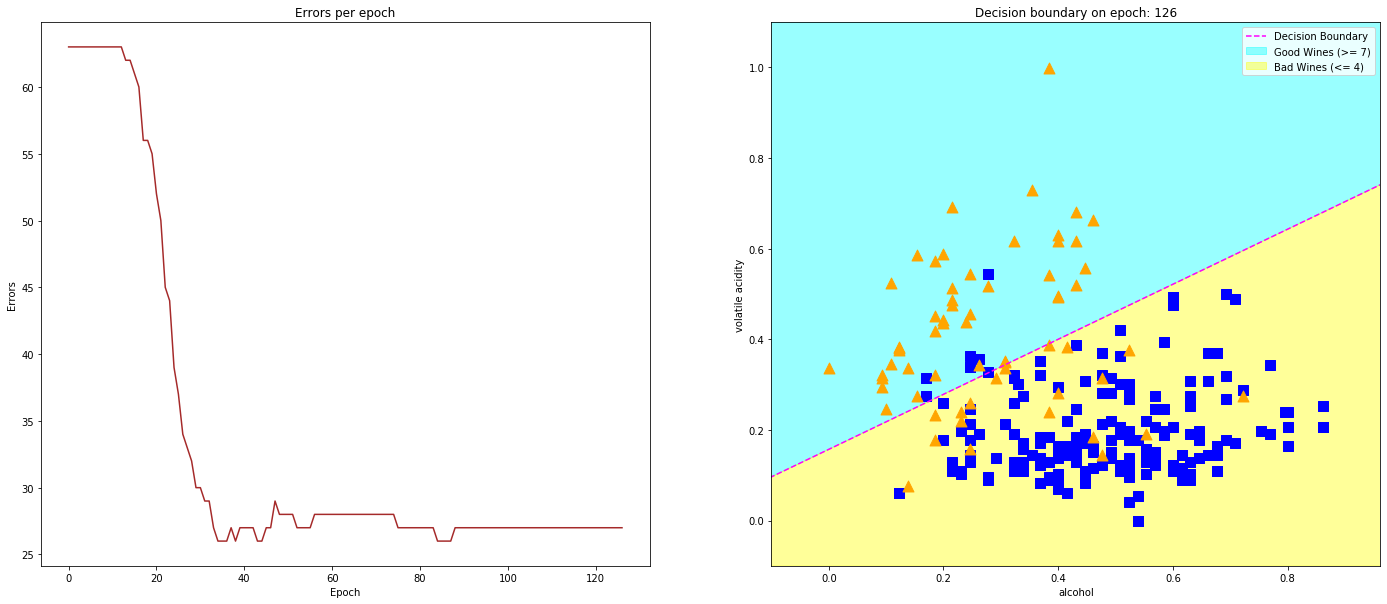

In [62]:
X, y = train_split(scaled_data, ['alcohol', 'volatile acidity'], 7, 4, binary=False)
adaline = Adaline(0.005, epochs=0)
performance = adaline.fit(X, y, sgd=True)
print(f"Final number of errors: {performance[-1][1]}")
fig = plot_performance(performance, scaled_data, ['alcohol', 'volatile acidity'], 7, 4)

### d) Find a good learning rate for your ADALINE and plot number of classification errors vs. epoch and the decision boundary of your ADALINE.
What settings tend to give the smallest number of classification errors? Support your reasoning with example plots!

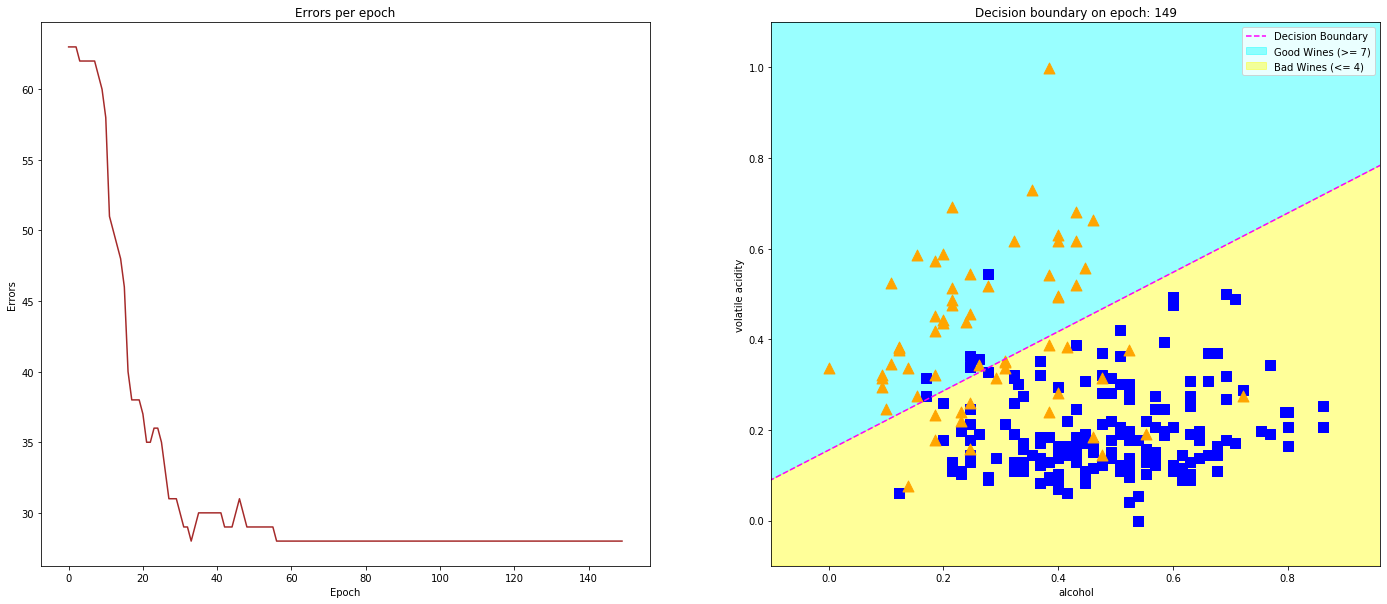

Final number of errors: 28


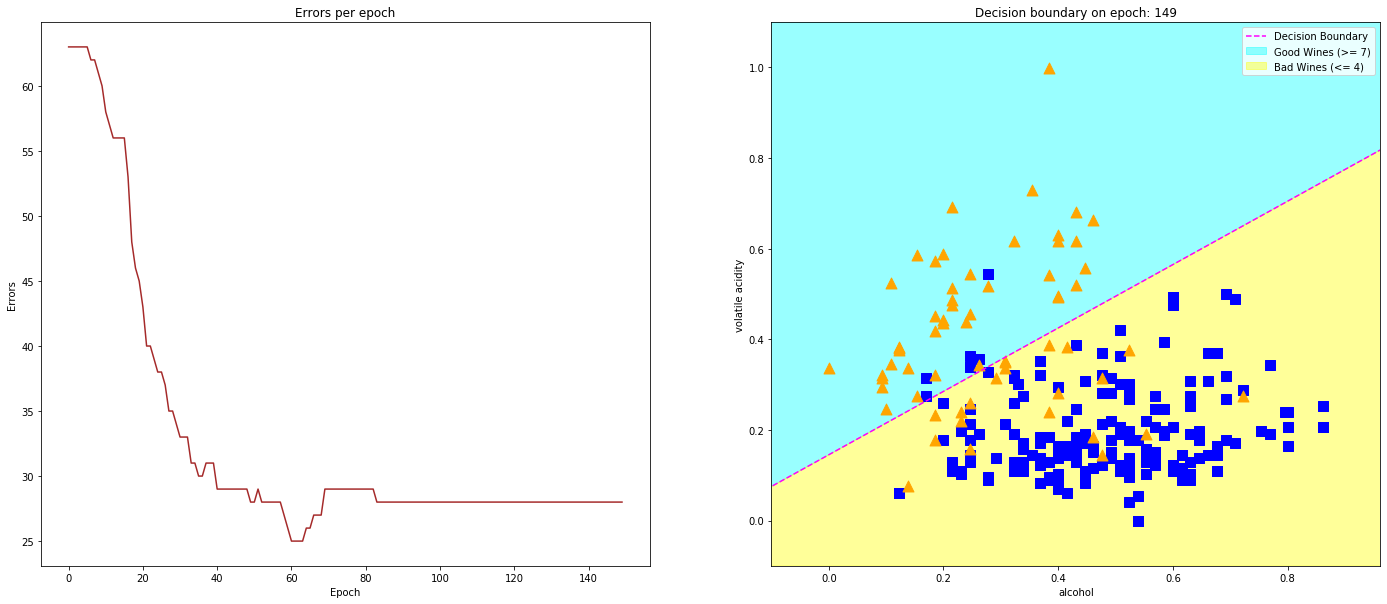

Final number of errors: 28


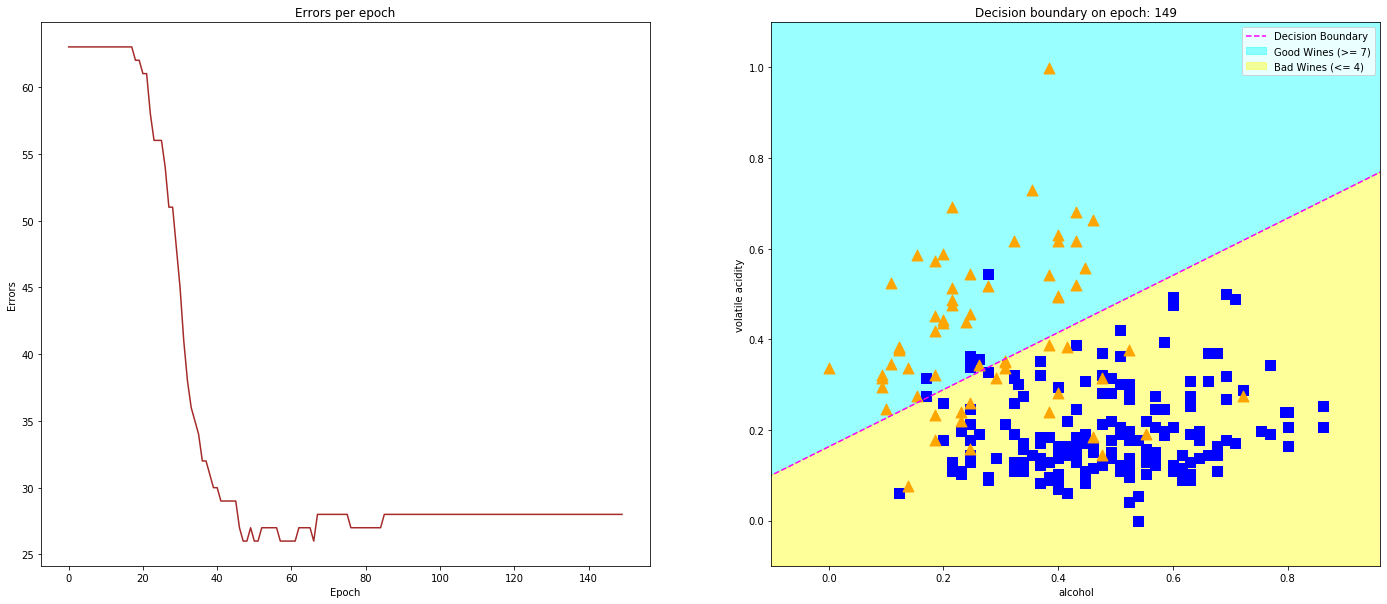

Final number of errors: 28


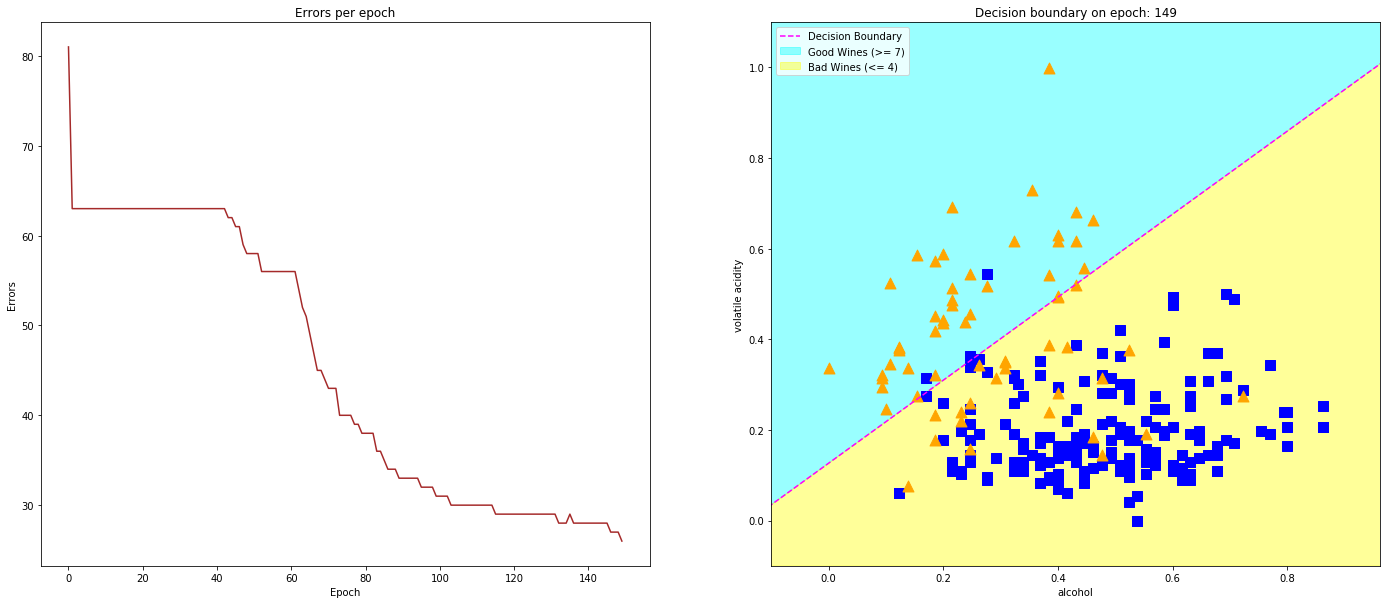

Final number of errors: 26


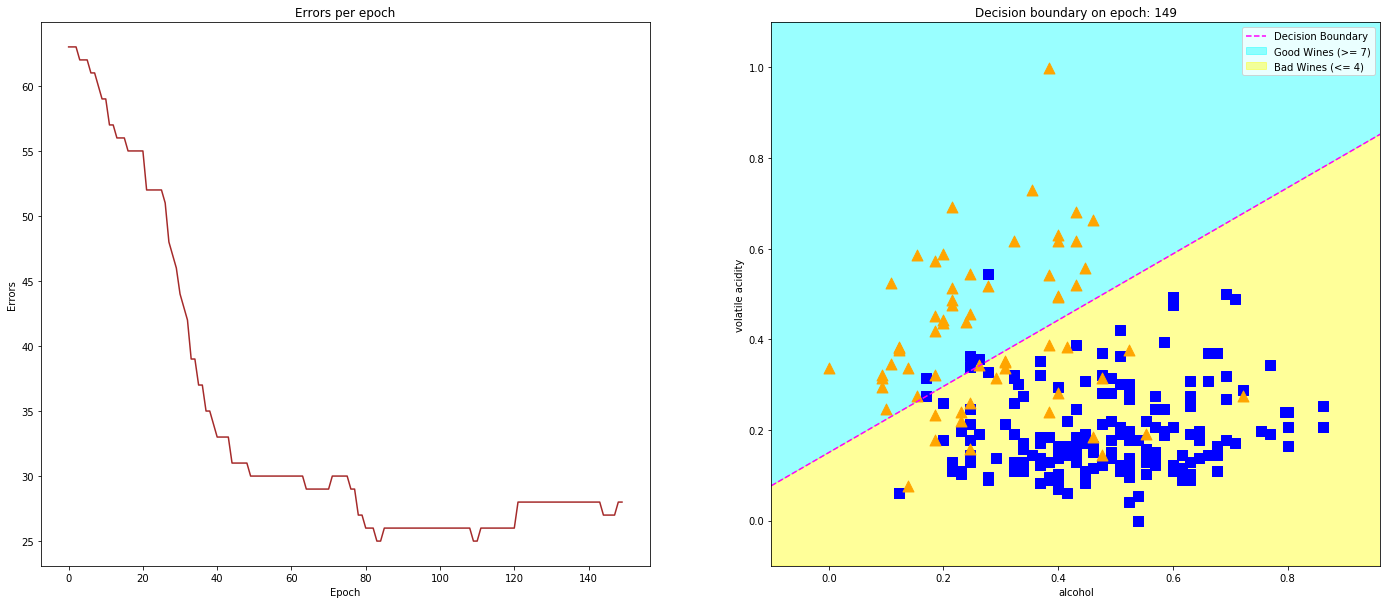

Final number of errors: 28


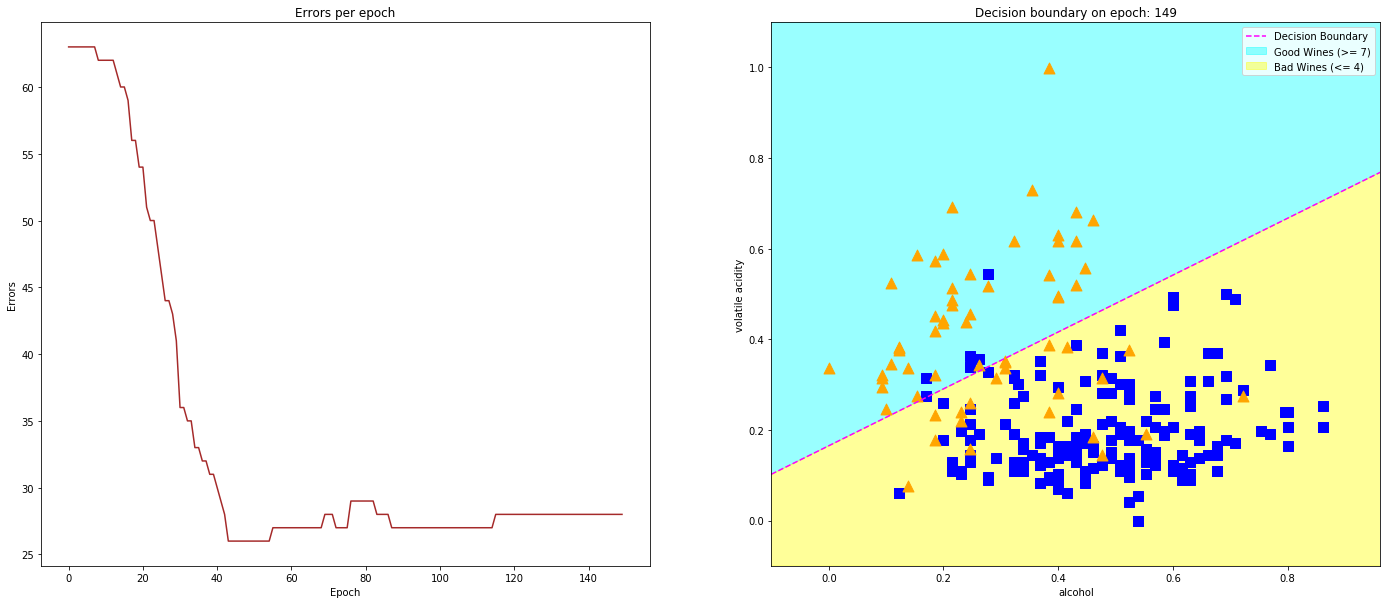

Final number of errors: 28


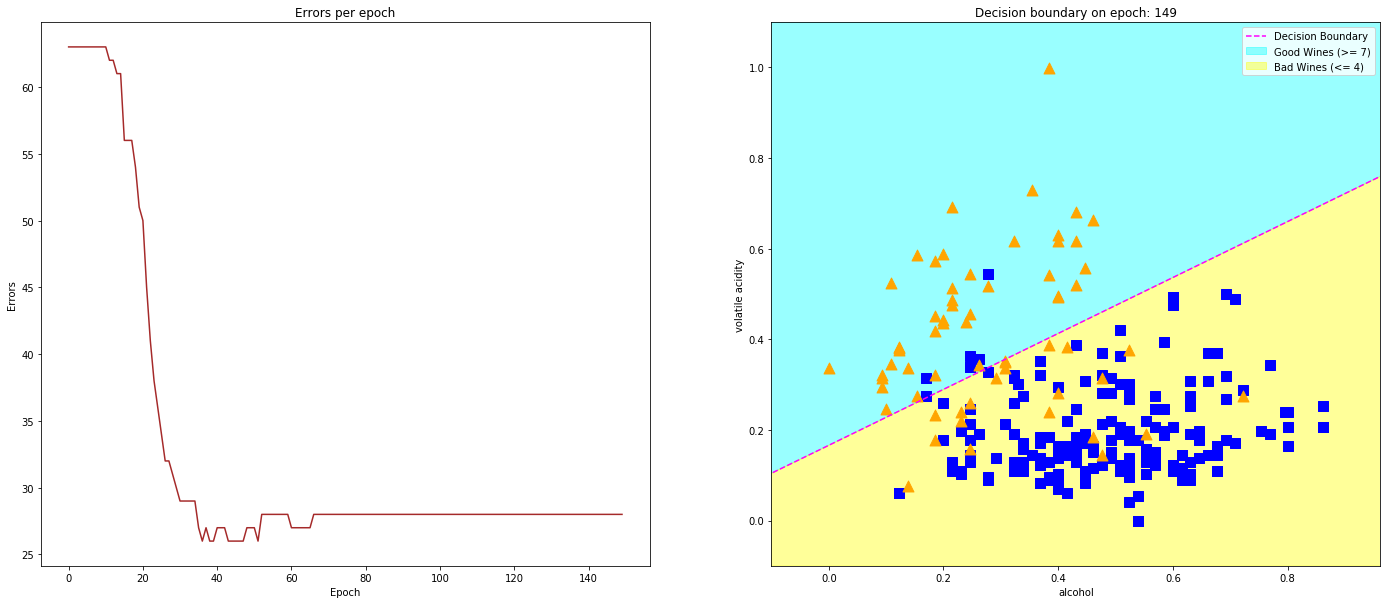

Final number of errors: 28
Best learning rate: 0.0013


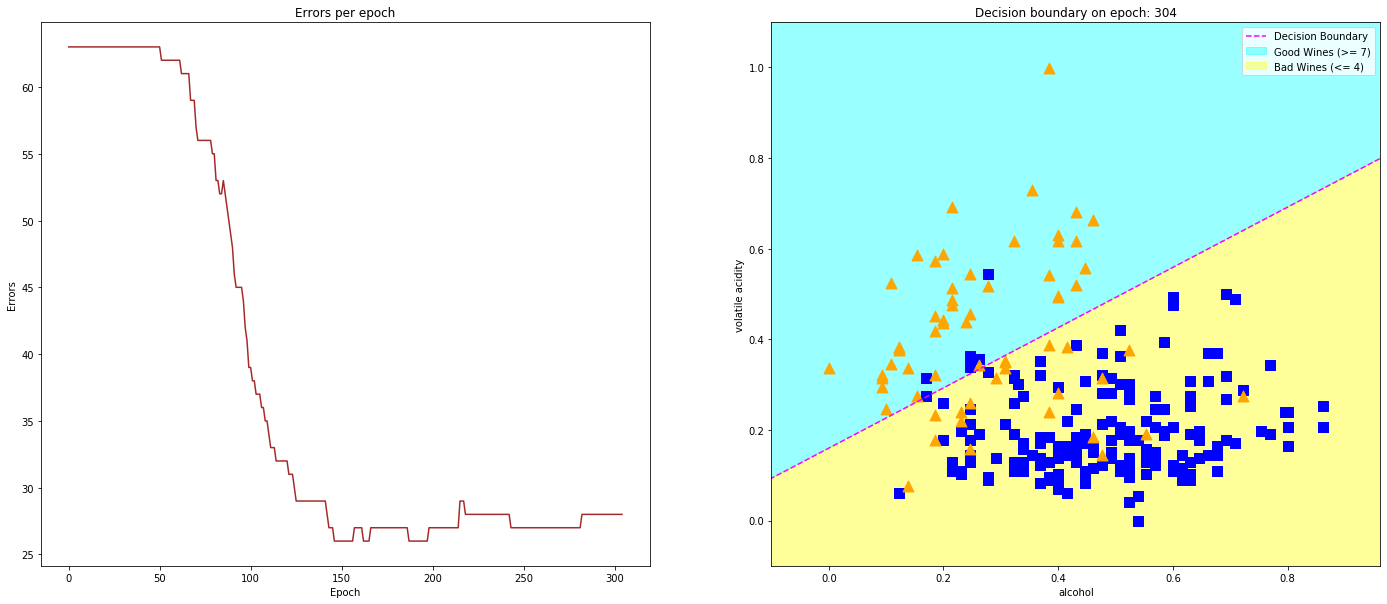

Final number of errors: 28


In [105]:
X, y = train_split(scaled_data, ['alcohol', 'volatile acidity'], 7, 4, binary=False)
learning_rate = Adaline.choose_learning_rate(X, y, 7, sgd=False)
print(f"Best learning rate: {learning_rate}")

adaline = Adaline(learning_rate, epochs=0)
performance = adaline.fit(X, y, sgd=False)
fig = plot_performance(performance, scaled_data, ['alcohol', 'volatile acidity'], 7, 4)
plt.show(fig)
print(f"Final number of errors: {performance[-1][1]}")